In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from tqdm import tqdm
import time

train = pd.read_csv("CSV_train.csv",low_memory=False,delimiter=';')
test=pd.read_csv("CSV_test.csv",low_memory=False,delimiter=',')
hidden=pd.read_csv("CSV_hidden_test.csv",low_memory=False,delimiter=',')

In [2]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136786 entries, 0 to 136785
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   WELL                              136786 non-null  object 
 1   DEPTH_MD                          136786 non-null  float64
 2   X_LOC                             136727 non-null  float64
 3   Y_LOC                             136727 non-null  float64
 4   Z_LOC                             136727 non-null  float64
 5   GROUP                             136786 non-null  object 
 6   FORMATION                         129712 non-null  object 
 7   CALI                              131141 non-null  float64
 8   RSHA                              39097 non-null   float64
 9   RMED                              136199 non-null  float64
 10  RDEP                              136727 non-null  float64
 11  RHOB                              119826 non-null  f

In [3]:
# storing length of datasets 
train_len = train.shape[0] 
test_len = test.shape[0]
All_data = pd.concat((train,test,hidden)).reset_index(drop=True) 

lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}
All_data['Lithology'] = All_data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
All_data

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,Lithology
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0,Shale
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0,Shale
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0,Shale
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0,Shale
4,15/9-13,495.1360,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429689,35/9-7,2973.2988,536096.06250,6793022.0,-2943.444580,BAAT GP.,Etive Fm.,8.276272,NaN,2.820439,...,136.911575,NaN,0.502458,NaN,2.311106,24.306124,NaN,65000,2.0,Shale
1429690,35/9-7,2973.4508,536096.06250,6793022.0,-2943.595947,BAAT GP.,Etive Fm.,8.267273,NaN,3.020778,...,137.583923,NaN,0.374753,NaN,1.853418,22.201078,NaN,65000,2.0,Shale
1429691,35/9-7,2973.6028,536096.06250,6793022.0,-2943.747559,BAAT GP.,Etive Fm.,8.250099,NaN,2.795711,...,138.310898,NaN,0.211487,NaN,1.325961,20.096741,NaN,65000,2.0,Shale
1429692,35/9-7,2973.7548,536096.06250,6793022.0,-2943.899170,BAAT GP.,Etive Fm.,NaN,NaN,2.658694,...,137.592819,NaN,0.147950,NaN,1.260347,17.992323,NaN,65000,2.0,Shale


In [4]:
#dropping columns with high missing values
drop_cols = ['SGR', 'ROPA', 'RXO', 'MUDWEIGHT','DCAL','RMIC','FORCE_2020_LITHOFACIES_CONFIDENCE']
All_data_drop = All_data.drop(drop_cols, axis=1)


In [5]:
All_data_drop

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,NPHI,PEF,DTC,SP,BS,ROP,DTS,DRHO,FORCE_2020_LITHOFACIES_LITHOLOGY,Lithology
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,-0.574928,65000,Shale
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,-0.570188,65000,Shale
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,-0.574245,65000,Shale
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,-0.586315,65000,Shale
4,15/9-13,495.1360,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,-0.597914,65000,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429689,35/9-7,2973.2988,536096.06250,6793022.0,-2943.444580,BAAT GP.,Etive Fm.,8.276272,NaN,2.820439,...,NaN,NaN,75.260658,NaN,8.5,15.195305,136.911575,0.502458,65000,Shale
1429690,35/9-7,2973.4508,536096.06250,6793022.0,-2943.595947,BAAT GP.,Etive Fm.,8.267273,NaN,3.020778,...,NaN,NaN,74.868301,NaN,8.5,15.770223,137.583923,0.374753,65000,Shale
1429691,35/9-7,2973.6028,536096.06250,6793022.0,-2943.747559,BAAT GP.,Etive Fm.,8.250099,NaN,2.795711,...,NaN,NaN,74.848122,NaN,8.5,16.418465,138.310898,0.211487,65000,Shale
1429692,35/9-7,2973.7548,536096.06250,6793022.0,-2943.899170,BAAT GP.,Etive Fm.,NaN,NaN,2.658694,...,NaN,NaN,74.964027,NaN,8.5,17.037945,137.592819,0.147950,65000,Shale


In [6]:
# drop2

In [7]:
All_data_drop.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC',
       'SP', 'BS', 'ROP', 'DTS', 'DRHO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'Lithology'],
      dtype='object')

In [8]:
#Inputing missing values by introducing median 
from sklearn.impute import SimpleImputer

numeric_header=['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC',
       'SP', 'BS', 'ROP', 'DTS', 'DRHO', 'FORCE_2020_LITHOFACIES_LITHOLOGY'
       ]
categorical_header=['WELL','GROUP', 'FORMATION','Lithology']
numeric=All_data_drop.select_dtypes(include=[np.number])
categorical= All_data_drop.select_dtypes(exclude=[np.number])
miss = SimpleImputer(missing_values=np.nan, strategy='median')
miss.fit(numeric)
numeric_imp = miss.fit_transform(numeric)
numeric_imp=pd.DataFrame(numeric_imp, columns=numeric_header)
miss2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
miss2.fit(categorical)
categorical_imp = miss2.fit_transform(categorical)
categorical_imp=pd.DataFrame(categorical_imp, columns=categorical_header)
frames = [numeric_imp,categorical_imp]
  
result = pd.concat(frames,axis=1, join='inner')
result

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,SP,BS,ROP,DTS,DRHO,FORCE_2020_LITHOFACIES_LITHOLOGY,WELL,GROUP,FORMATION,Lithology
0,494.5280,437641.96875,6470972.5,-469.501831,19.480835,1.398049,1.611410,1.798681,1.884186,80.200851,...,24.612379,12.250001,34.636410,189.362198,-0.574928,65000.0,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
1,494.6800,437641.96875,6470972.5,-469.653809,19.468800,1.398049,1.618070,1.795641,1.889794,79.262886,...,23.895531,12.250001,34.636410,189.362198,-0.570188,65000.0,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
2,494.8320,437641.96875,6470972.5,-469.805786,19.468800,1.398049,1.626459,1.800733,1.896523,74.821999,...,23.916357,12.250001,34.779556,189.362198,-0.574245,65000.0,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
3,494.9840,437641.96875,6470972.5,-469.957794,19.459282,1.398049,1.621594,1.801517,1.891913,72.878922,...,23.793688,12.250001,39.965164,189.362198,-0.586315,65000.0,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
4,495.1360,437641.96875,6470972.5,-470.109772,19.453100,1.398049,1.602679,1.795299,1.880034,71.729141,...,24.104078,12.250001,57.483765,189.362198,-0.597914,65000.0,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429689,2973.2988,536096.06250,6793022.0,-2943.444580,8.276272,1.398049,2.820439,3.158570,2.331407,90.720284,...,54.270451,8.500000,15.195305,136.911575,0.502458,65000.0,35/9-7,BAAT GP.,Etive Fm.,Shale
1429690,2973.4508,536096.06250,6793022.0,-2943.595947,8.267273,1.398049,3.020778,3.332977,2.331407,87.062027,...,54.270451,8.500000,15.770223,137.583923,0.374753,65000.0,35/9-7,BAAT GP.,Etive Fm.,Shale
1429691,2973.6028,536096.06250,6793022.0,-2943.747559,8.250099,1.398049,2.795711,3.044179,2.331407,86.115921,...,54.270451,8.500000,16.418465,138.310898,0.211487,65000.0,35/9-7,BAAT GP.,Etive Fm.,Shale
1429692,2973.7548,536096.06250,6793022.0,-2943.899170,12.515673,1.398049,2.658694,2.847681,2.331407,89.497131,...,54.270451,8.500000,17.037945,137.592819,0.147950,65000.0,35/9-7,BAAT GP.,Etive Fm.,Shale


In [9]:
# encoding categorical variables
result['GROUP_encoded'] = result['GROUP'].astype('category')
result['GROUP_encoded'] = result['GROUP_encoded'].cat.codes

result['FORMATION_encoded'] = result['FORMATION'].astype('category')
result['FORMATION_encoded'] = result['FORMATION_encoded'].cat.codes

result['WELL_encoded'] = result['WELL'].astype('category')
result['WELL_encoded'] = result['WELL_encoded'].cat.codes

result['Lithology_encoded'] = result['FORCE_2020_LITHOFACIES_LITHOLOGY'].astype('category')
result['Lithology_encoded'] = result['Lithology_encoded'].cat.codes

In [10]:
#dropping categorial features replaces beforehan by encoded features
# drop2 = All_data_drop.drop(['GROUP', 'FORMATION','WELL','FORCE_2020_LITHOFACIES_LITHOLOGY','Lithology'], axis=1)

# # splitting dataset into training, test, and hidden sets
# train_prep = drop2[:train_len].copy()
# test_prep = drop2[train_len:(train_len+test_len)].copy()
# hidden_prep = drop2[(train_len+test_len):].copy()

In [11]:
# train_prep1= train_prep.copy()
# test_prep1= test_prep.copy()
# hidden_prep1= hidden_prep.copy()

In [12]:
train_imp = result[:train_len].copy()
test_imp = result[train_len:(train_len+test_len)].copy()
hidden_imp = result[(train_len+test_len):].copy()

In [13]:
print(train_imp.shape)
print(test_imp.shape)
print(hidden_imp.shape)

(1170511, 27)
(136786, 27)
(122397, 27)


In [14]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
x_header=['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DRHO',
       'GROUP_encoded', 'FORMATION_encoded', 'WELL_encoded']
y_header=['Lithology_encoded']
x_train = train_imp[x_header]
y_train = train_imp[y_header]
x_test = test_imp[x_header]
y_test = test_imp[y_header]
x_hidden = hidden_imp[x_header]
y_hidden = hidden_imp[y_header]

##Min-Max scaler 
scaler = MinMaxScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_hidden_scaled = x_hidden.copy()

x_train_scaled.iloc[:,:18] = scaler.fit_transform(x_train_scaled.iloc[:,:18])
x_test_scaled.iloc[:,:18] = scaler.transform(x_test_scaled.iloc[:,:18])
x_hidden_scaled.iloc[:,:18] = scaler.transform(x_hidden_scaled.iloc[:,:18])



In [15]:
#  import numpy as np
#     matrix_path = '/content/drive/MyDrive/Thesis_data/penalty_matrix.npy'
#     A = np.load(matrix_path)
#     S = 0.0
#     y_true = y_true.astype(int)
#     y_pred = y_pred.astype(int)
#     for i in range(0, y_true.shape[0]):
#         S -= A[y_true[i], y_pred[i]]
#     return S/y_true.shape[0]
    
# # Confusion Matrix Function

# def confusion_matrix(y_true, y_pred):
      
#     """Plots a confusion matrix normalized by the number of predictions a particular
#     machine learning algorithm has. By ormalize we look at the number of predictions
#     the model gets right.
#     Parameters
#     ----------
#     y_true: list
#       The actual lithologies given by the datasets provider.
#     y_pred: list
#       The predicted lithofacies obtained by a particular machine learning model.
#     Returns

In [16]:
A = np.load('penalty_matrix.npy')
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [18]:
#Supervised Algorithms
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from pprint import pprint
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
import xgboost
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
#Comparing base models accuracies by using k-fold cross validation - 10 folds

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier


model_knn = KNeighborsClassifier(leaf_size= 20, metric= 'minkowski', n_neighbors= 1, p=1, weights='uniform')

model_knn.fit(x_train_scaled, y_train.values.ravel())

train_pred_knn = model_knn.predict(x_train_scaled)
open_pred_knn = model_knn.predict(x_test_scaled)
hidden_pred_knn = model_knn.predict(x_hidden_scaled)
#Printing Reports 



C:\Users\Ayori\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [19]:
print('-----------------------TRAIN SET REPORT---------------------')
print("Open set RMSE:", np.sqrt(mean_squared_error(y_train, train_pred_knn)))
print('Open set penalty matrix score:', score(y_train.values, train_pred_knn))
print('Open set report:', classification_report(y_train, train_pred_knn))
print('-----------------------OPEN SET REPORT---------------------')
print("Open set RMSE:", np.sqrt(mean_squared_error(y_test, open_pred_knn)))
print('Open set penalty matrix score:', score(y_test.values, open_pred_knn))
print('Open set report:', classification_report(y_test, open_pred_knn))
print('-----------------------HIDDEN SET REPORT---------------------')
print("Hidden set RMSE:", np.sqrt(mean_squared_error(y_hidden, hidden_pred_knn)))
print('Hidden set penalty matrix score:', score(y_hidden.values, hidden_pred_knn))
print('Hidden set report:', classification_report(y_hidden, hidden_pred_knn))

-----------------------TRAIN SET REPORT---------------------
Open set RMSE: 0.0
Open set penalty matrix score: [0.]
Open set report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    168937
           1       1.00      1.00      1.00    720803
           2       1.00      1.00      1.00    150455
           3       1.00      1.00      1.00     56320
           4       1.00      1.00      1.00     10513
           5       1.00      1.00      1.00      1688
           6       1.00      1.00      1.00     33329
           7       1.00      1.00      1.00      1085
           8       1.00      1.00      1.00      8213
           9       1.00      1.00      1.00      3820
          10       1.00      1.00      1.00       103
          11       1.00      1.00      1.00     15245

    accuracy                           1.00   1170511
   macro avg       1.00      1.00      1.00   1170511
weighted avg       1.00      1.00      1.00   1170511



C:\Users\Ayori\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ayori\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ayori\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hidden set penalty matrix score: [-1.186996]
Hidden set report:               precision    recall  f1-score   support

           0       0.53      0.54      0.53     14045
           1       0.77      0.60      0.68     71827
           2       0.21      0.37      0.27     12283
           3       0.35      0.57      0.43      8374
           4       0.42      0.46      0.44      2905
           5       0.00      0.00      0.00       287
           6       0.38      0.29      0.33      4396
           7       0.55      0.62      0.59       597
           8       0.98      0.70      0.82      6498
           9       0.57      0.16      0.25       244
          11       0.10      0.47      0.17       941

    accuracy                           0.56    122397
   macro avg       0.44      0.44      0.41    122397
weighted avg       0.64      0.56      0.59    122397



In [ ]:
result['Lithology_encoded'].unique() 

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
facies_colors = ['#F4D03F','#7ccc19','#196F3D','#160599','#2756c4','#3891f0','#80d4ff','#87039e','#ec90fc','#FF4500','#000000','#DC7633']
facies_labels = ['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']


#Facies_color_map
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
    
def pred_log(logs, well_num, facies_colors, n_pred):
    wells = logs['WELL'].unique()
    logs = logs[logs['WELL'] == wells[well_num]]
    logs = logs.sort_values(by='DEPTH_MD')        #Sorting log by depth
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    top = logs.DEPTH_MD.min()
    bot = logs.DEPTH_MD.max()
       
    f, ax = plt.subplots(nrows=1, ncols=(12+n_pred), figsize=(15, 12))
    log_colors = ['black', 'red', 'blue', 'green', 'purple','black', 'red', 'blue', 'green', 'purple', 'black', 'red', 'blue', 'green', 'purple', 'black', 'black', 'red', 'blue', 'green', 'purple', 'black', 'black', 'red', 'blue', 'green', 'purple', 'black']

    for i in range(7,18):
      ax[i-7].plot(logs.iloc[:,i], logs.DEPTH_MD, color=log_colors[i])
      ax[i-7].set_ylim(top, bot)
      #ax[i-7].set_xlim(logs.iloc[:,i].min(), logs.iloc[:,i].max())

      ax[i-7].set_xlabel(str(logs.columns[i]))
      ax[i-7].invert_yaxis()
      ax[i-7].grid()

    for j in range((-1-n_pred), 0):
      label = np.repeat(np.expand_dims(logs.iloc[:,j].values, 1), 100, 0)
      im = ax[j].imshow(label, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=12)
      ax[j].set_xlabel(str(logs.columns[j]))

    divider = make_axes_locatable(ax[-1])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((12*' ').join(['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
        
    f.suptitle('WELL LOGS '+str(wells[well_num]), fontsize=14,y=0.94)

In [21]:
#Storing results
test_knn = test_imp.copy()
hidden_knn = hidden_imp.copy()
#Saving Results
test_knn['KNN_tuned'] = open_pred_knn
hidden_knn['KNN_tuned'] = hidden_pred_knn

test_knn.to_csv('test_knn.csv', index=False)
hidden_knn.to_csv('hidden_knn.csv', index=False)

In [22]:
test_knn = pd.read_csv('test_knn.csv')
hidden_knn = pd.read_csv('hidden_knn.csv')

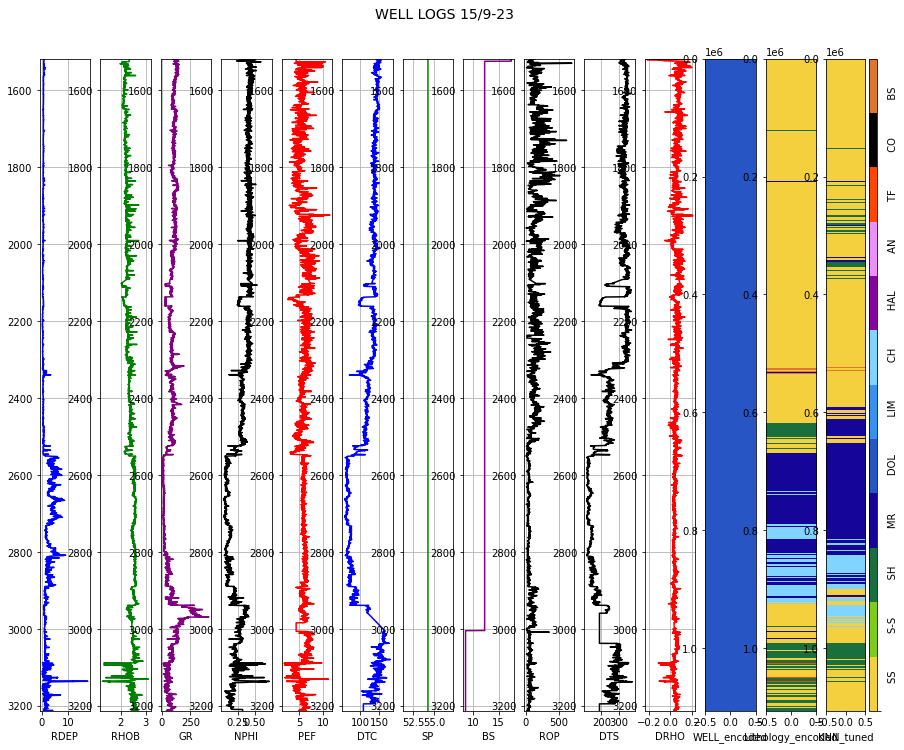

In [23]:
#Plotting predictions - HIDDEN DATASET
for i in range(1):
  pred_log(hidden_knn, i, facies_colors, 2)

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (12).

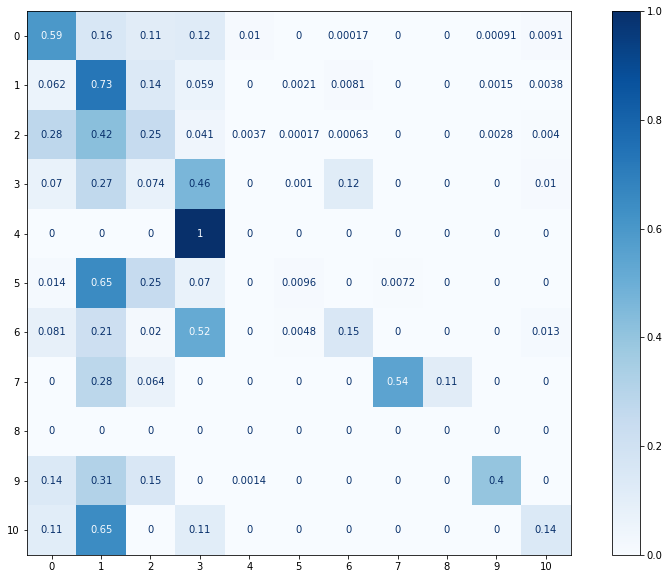

In [24]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
class_names = ['Sandstone','Sandstone/Shale','Shale', 'Marl', 'Dolomite', 'Limestone', 'Chalk', 'Halite', 'Anhydrite', 'Tuff', 'Coal','Basement']
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
disp = plot_confusion_matrix(model_knn, x_test_scaled, y_test,
                             cmap=plt.cm.Blues,
                             normalize="true", ax=ax,display_labels=class_names)
disp.ax_.set_title("confusion matrix for KNN base model")